# Exploring Models

First bring in some libs and import some functions from the utils directory

In [1]:
# import a few things 
import sys # General sys
import numpy as np
import pandas as pd

sys.path.insert(0, "../utils/") # add the path to python so we have relaitve imports

import frames as fm
import date_funcs as datef
import plot_maker as pm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso, ElasticNet

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



In [2]:
#Pick an influencer user name
myuser= 'chiaraferragni'

ppdf = fm.make_user_df(myuser) # Take the json for the profile 
pdf = fm.clean_df(ppdf)#clean the json for the scraped and with follower data
ddf = fm.make_vision_df(pdf)# M
df = ddf.dropna()# drop anything that is not file
df = fm.make_label_vision_df(df)# note the datetime error is ok
print df.columns

predf , postdf = datef.make_pre_post_algodf(df)# Break the df into before and after the smartfeed algo 

/Users/ryangrosso/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  """


Index([u'Nlikes', u'images', u'user', u'uid', u'nfollowers', u'nfollowers_2',
       u'nfollowers_3', u'datetime', u'hour', u'hour_3', u'year', u'weekday',
       u'weekday_hr', u'weekday_hr_3', u'weekday_hr_6', u'has_title',
       u'title_length', u'has_emo', u'title_text', u'emo', u'is_car',
       u'is_loc', u'location', u'is_tag', u'ntag', u'im_id', u'post_count',
       u'nfaces', u'face_frac', u'JLK', u'SLK', u'ALK', u'SPLK', u'HLK',
       u'is_face', u'bjlk', u'balk', u'bslk', u'bsplk', u'bhlk'],
      dtype='object')


In [4]:
# Base features we will use in the model
base_feat = ["nfollowers",'post_count','weekday',"ntag",'face_frac','bjlk','bslk','bhlk','balk','bsplk','weekday_hr_6','is_tag','has_title','has_emo',"is_car"]
# features to be one hot encoded
dummy_feat =["weekday_hr_6",'weekday']

predf = predf.sample(frac=1).reset_index(drop=True)# for good measure random shuffle the data frame

# Make test/train samples for pre ,Test Train split with frozen random state
prefeat_df =predf[base_feat]
prefeat_df = pd.get_dummies(prefeat_df, columns=dummy_feat)# This is X aka features
preY = predf["Nlikes"]

#Split the dataframe for cross validation
preX_train, preX_test, prey_train, prey_test = train_test_split(prefeat_df, preY, test_size=0.2, random_state=0)

#postdf = postdf.sample(frac=1).reset_index(drop=True)
postfeat_df =postdf[base_feat]
postfeat_df = pd.get_dummies(postfeat_df, columns=dummy_feat)# This is X aka features
postY = postdf["Nlikes"]

postX_train, postX_test, posty_train, posty_test = train_test_split(postfeat_df, postY, test_size=0.3, random_state=0)
print'We have {} Features in this model.'.format(len(prefeat_df.columns))

We have 48 Features in this model.


In [5]:
# Make a def that can make our model
def make_model(myestimator,mygrid,myX, myy):
    '''
    input: the estimator, the dict for the grid search, the X features, the pred Y
    return: a model that is best fit from the given grid search
    '''
    CV_rfc = GridSearchCV(estimator=myestimator, param_grid=mygrid,cv=10,n_jobs=1)
    CV_rfc.fit(myX, myy) 
    pv = CV_rfc.best_params_
    print pv
    return CV_rfc

In [6]:
# my grid  for Ridge
ridge_est = Ridge()
ridge_grid ={
    "alpha": [x for x in range(190,200)]
    }
ridge_model = make_model(ridge_est,ridge_grid,postX_train,posty_train)
ridge_model.score(postX_test,posty_test)

{'alpha': 196}


0.68254762664867397

In [7]:
# my grid  for Lasso
lasso_est = Lasso()
lasso_grid ={
    "alpha": [x for x in range(750,780)]
    }
lasso_model= make_model(lasso_est,lasso_grid,postX_train,posty_train)
lasso_model.score(postX_test,posty_test)

{'alpha': 767}


0.68194194460914459

In [9]:
# my grid for Enet
enet_est = ElasticNet(max_iter=100000)
enet_grid ={
    "alpha": [0.01,0.1,0.5],
    "l1_ratio": [0.001,0.01,0.1]
    }
enet_model= make_model(enet_est,enet_grid,postX_train,posty_train)
enet_model.score(postX_test,posty_test)


{'alpha': 0.1, 'l1_ratio': 0.001}


0.68253427621208462

In [10]:
#my grid for linear model
rf_est = RandomForestRegressor()
rf_grid ={
    "n_estimators": [900,1000,1200],
    "max_depth": [6,7,8],
    "max_features": [40,45,48]
    }

rf_model= make_model(rf_est,rf_grid,postX_train,posty_train)
rf_model.score(postX_test,posty_test)


{'max_features': 48, 'n_estimators': 1000, 'max_depth': 6}


0.70667612117831935

## Move on to looking at the learning curves

Inspect if the learning scores are converging and leveling off

In [6]:
#Definition for making the learing curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R2_Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Shuffle split for the cross val
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

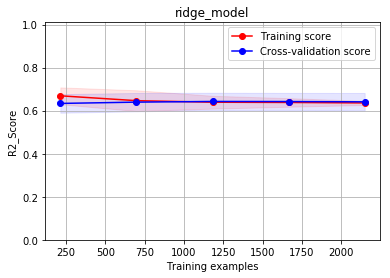

In [7]:
plot_learning_curve(ridge_model, 'Ridge Model', postfeat_df, postY, ylim=(0.0, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

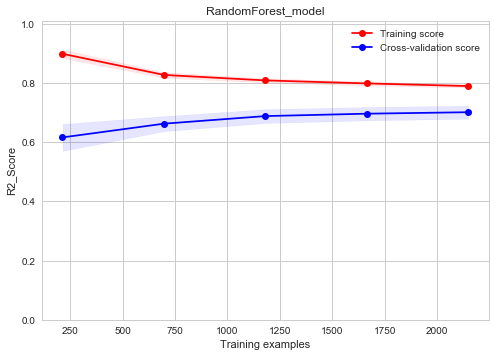

In [107]:
plot_learning_curve(rf_model, 'RandomForest Model', postfeat_df, postY, ylim=(0.0, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

In [8]:
plot_learning_curve(lasso_model, 'Lasso Model', postfeat_df, postY, ylim=(0.0, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [ ]:
plot_learning_curve(enet_model, 'eleasticnet_model', postfeat_df, postY, ylim=(0.0, 1.01), cv=cv, n_jobs=1)
plt.grid(True)
plt.show()

In [60]:
#Make plots of all models : Ridge Model, Lasso, Enet, RF

#Seaborn is funny so I will import it here
import seaborn as sns
sns.set_style("whitegrid")

def make_modelcv(myx,myy): 
    sns.boxplot(x=myx, y=myy,whis=np.inf)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel(r'$r^2 Score$',size=20)
    #plt.ylabel('Model Type',size=20)
    plt.xlim(0,1)
    plt.grid(True)
    plt.show()

# We are expecting Enet, Ridge, and Lasso to be very similiar. 
# From the params with Enet we see that the L1 and L2 are dropping out.... but lets plot them anyways
model_vals = []
model_names=[ridge_model,enet_model,rf_model,lasso_model]
for m in model_names:
    myscores = cross_val_score(m, postfeat_df, postY, cv=ShuffleSplit(n_splits=10,test_size=.2,random_state=42))
    model_vals.append(np.asarray(myscores))



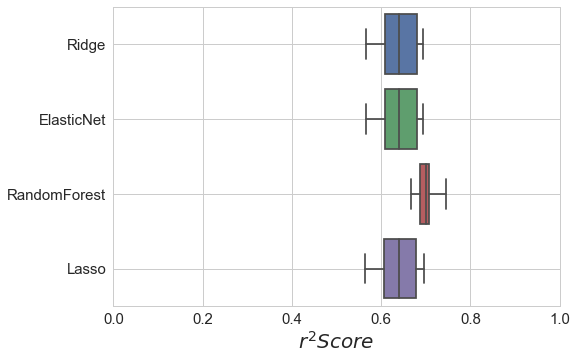

In [105]:
model_name=['Ridge','ElasticNet','RandomForest','Lasso']
make_modelcv(model_vals,model_name)

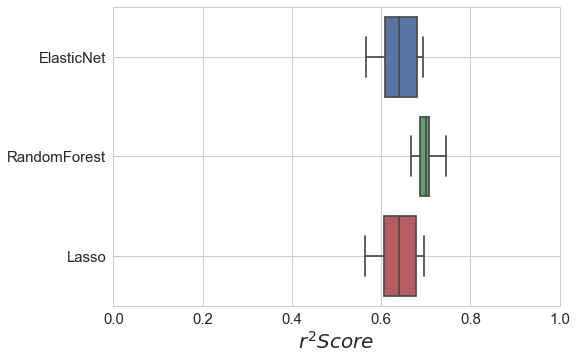

In [106]:
model_name=['ElasticNet','RandomForest','Lasso']
make_modelcv(model_vals[1:],model_name)